In [42]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, GRU, GaussianNoise
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam

In [2]:
DATA_DIR = '../../pickles'

In [3]:
df = pd.read_pickle(os.path.join(DATA_DIR, 'station1_pm_normalized.pkl'))
df.head(10)

,date,ref,PM_6182,PM_6179,PM_617B,PM25_6182,PM25_6179,PM25_617B,rh,t_grad,pressure,temp,pluvio
15,2017-09-28 14:00:00,16.2,-1.179450,-1.139344,-1.135621,-1.184033,-1.129486,-1.149095,-1.118787,-0.921348,0.312759,1.982213,0.0
16,2017-09-28 14:15:00,9.6,-1.109019,-1.086416,-1.122920,-1.102387,-1.072487,-1.129116,-1.127870,-0.976013,0.331953,2.052982,0.0
17,2017-09-28 14:30:00,10.3,-1.179450,-1.171101,-1.258406,-1.177752,-1.169386,-1.253987,-1.236869,-1.085343,0.312759,2.076572,0.0
18,2017-09-28 14:45:00,9.4,-1.138365,-1.001731,-1.207599,-1.140070,-1.009787,-1.224018,-1.264119,-0.812018,0.312759,2.005803,0.0
19,2017-09-28 15:00:00,10.7,-1.167711,-1.165808,-1.139855,-1.165191,-1.169386,-1.149095,-1.146036,-0.921348,0.312759,1.864265,0.0
20,2017-09-28 15:15:00,10.7,-1.167711,-1.202857,-1.038241,-1.158911,-1.197885,-1.039208,-1.055204,-0.866683,0.312759,1.746317,0.0
21,2017-09-28 15:30:00,9.6,-1.079673,-1.171101,-1.008603,-1.070985,-1.163686,-0.999249,-0.964371,-0.812018,0.312759,1.651959,0.0
22,2017-09-28 15:45:00,10.2,-1.032720,-1.134051,-0.995901,-1.033302,-1.123786,-0.989259,-0.891705,-0.757353,0.312759,1.581190,0.0
23,2017-09-28 16:00:00,9.8,-1.044458,-1.097001,-0.911222,-1.039583,-1.095286,-0.919331,-0.855372,-0.757353,0.312759,1.534011,0.0
24,2017-09-28 16:15:00,8.9,-1.044458,-1.044073,-1.182195,-1.039583,-1.038287,-1.174070,-0.855372,-0.702688,0.331953,1.486832,0.0


In [4]:
def from_dataframe_to_xy(df):
    return (np.array(df[['PM_6182', 'PM_6179', 'PM_617B', 'PM25_6182', 'PM25_6179', 'PM25_617B', 'temp', 'rh', 't_grad', 'pressure', 'pluvio']]),
            np.array(df['ref']))

def split_dataframe(dataframe, percent):
    nb_rows = int(np.floor(percent * len(dataframe)))
    return dataframe[:nb_rows], dataframe[nb_rows:]

In [5]:
def gru(nb_units, input_shape, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(GRU(nb_units, input_shape=input_shape, activation='relu'))#, recurrent_dropout=1))
    #model.add(Dense(nb_units, activation='relu'))
    
    opti = Adam(lr=0.0003)
    model.add(Dense(1, kernel_initializer='normal', activation='relu'))
    model.compile(loss=loss, optimizer=opti)
    
    return model

def gru_plus_dense(nb_units, input_shape, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(GRU(nb_units, input_shape=input_shape, activation='relu'))#, recurrent_dropout=1))
    model.add(Dense(nb_units, activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='relu'))
    opti = Adam(lr=0.0003)
    model.compile(loss=loss, optimizer=opti)
    
    return model

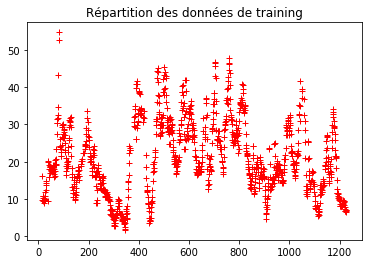

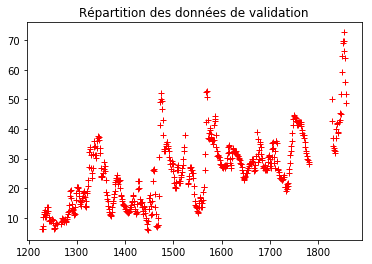

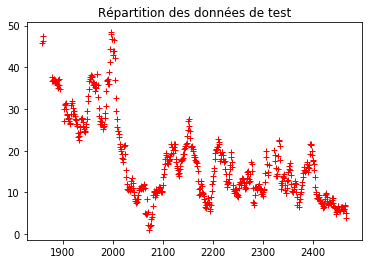

In [6]:
df_train, df_test = split_dataframe(df, 0.5)
df_valid, df_test = split_dataframe(df_test, 0.5)

X_train, y_train = from_dataframe_to_xy(df_train)
X_valid, y_valid = from_dataframe_to_xy(df_valid)
X_test, y_test = from_dataframe_to_xy(df_test)

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_valid= X_valid.reshape((X_valid.shape[0], 1,  X_valid.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

plt.plot(df_train['ref'], '+r')
plt.title('Répartition des données de training')
plt.show()

plt.plot(df_valid['ref'], '+r')
plt.title('Répartition des données de validation')
plt.show()

plt.plot(df_test['ref'], '+r')
plt.title('Répartition des données de test')
plt.show()

In [27]:
model = gru(32, X_train.shape[1:])
early_stopping = EarlyStopping(patience=10)
reduce_lr_on_plateau = ReduceLROnPlateau()
history = model.fit(X_train, y_train, \
                    batch_size=32, \
                    epochs=1000, \
                    validation_data=(X_valid, y_valid), \
                    callbacks=[early_stopping, reduce_lr_on_plateau])

Train on 1037 samples, validate on 471 samples
Epoch 1/1000
1037/1037 [==============================] - 3s 3ms/step - loss: 536.4027 - val_loss: 880.3833
Epoch 2/1000
1037/1037 [==============================] - 2s 2ms/step - loss: 531.9506 - val_loss: 872.4786
Epoch 3/1000
1037/1037 [==============================] - 2s 2ms/step - loss: 523.1385 - val_loss: 859.1208
Epoch 4/1000
1037/1037 [==============================] - 2s 2ms/step - loss: 505.2158 - val_loss: 819.2356
Epoch 5/1000
1037/1037 [==============================] - 2s 2ms/step - loss: 245.1111 - val_loss: 242.6878
Epoch 6/1000
1037/1037 [==============================] - 2s 2ms/step - loss: 71.8965 - val_loss: 231.9516
Epoch 7/1000
1037/1037 [==============================] - 2s 2ms/step - loss: 62.1185 - val_loss: 235.2246
Epoch 8/1000
1037/1037 [==============================] - 2s 2ms/step - loss: 56.3998 - val_loss: 252.7601
Epoch 9/1000
1037/1037 [==============================] - 2s 2ms/step - loss: 52.5260 - val_

In [28]:
model.evaluate(X_test, y_test, verbose=0)

171.3021988919333

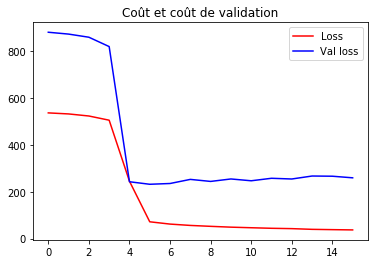

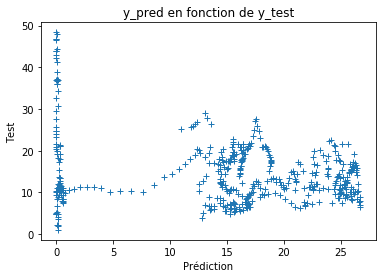

In [29]:
y_pred = model.predict(X_test)
plt.title('Coût et coût de validation')
line1,=plt.plot(history.history['loss'], label="Loss", linestyle='-', color='r')
line2,=plt.plot(history.history['val_loss'], label="Val loss", linestyle='-', color='b')
first_legend = plt.legend(handles=[line1, line2], loc=1)

plt.show()

plt.title('y_pred en fonction de y_test')

plt.plot(y_pred[:], y_test[:], '+')
plt.ylabel('Test')
plt.xlabel('Prédiction')
plt.show()

In [30]:
model = gru_plus_dense(32, X_train.shape[1:])
history = model.fit(X_train, y_train, \
                    batch_size=32, \
                    epochs=1000, \
                    validation_data=(X_valid, y_valid), \
                    callbacks=[early_stopping, reduce_lr_on_plateau])

Train on 1037 samples, validate on 471 samples
Epoch 1/1000
1037/1037 [==============================] - 3s 3ms/step - loss: 533.7949 - val_loss: 879.5206
Epoch 2/1000
1037/1037 [==============================] - 2s 2ms/step - loss: 526.3151 - val_loss: 867.8950
Epoch 3/1000
1037/1037 [==============================] - 2s 2ms/step - loss: 511.1216 - val_loss: 835.1444
Epoch 4/1000
1037/1037 [==============================] - 2s 2ms/step - loss: 313.6222 - val_loss: 184.0442
Epoch 5/1000
1037/1037 [==============================] - 2s 2ms/step - loss: 81.5254 - val_loss: 169.4463
Epoch 6/1000
1037/1037 [==============================] - 2s 2ms/step - loss: 65.9344 - val_loss: 208.5479
Epoch 7/1000
1037/1037 [==============================] - 2s 2ms/step - loss: 59.1289 - val_loss: 219.1015
Epoch 8/1000
1037/1037 [==============================] - 2s 2ms/step - loss: 51.4095 - val_loss: 260.6925
Epoch 9/1000
1037/1037 [==============================] - 2s 2ms/step - loss: 49.1823 - val_l

In [31]:
model.evaluate(X_test, y_test, verbose=0)

166.76628407601845

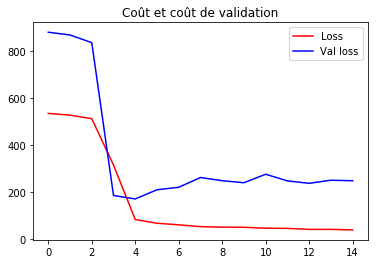

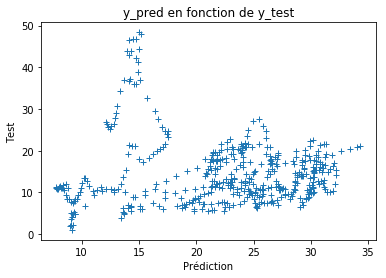

In [32]:
y_pred = model.predict(X_test)
plt.title('Coût et coût de validation')
line1,=plt.plot(history.history['loss'], label="Loss", linestyle='-', color='r')
line2,=plt.plot(history.history['val_loss'], label="Val loss", linestyle='-', color='b')
first_legend = plt.legend(handles=[line1, line2], loc=1)

plt.show()

plt.title('y_pred en fonction de y_test')

plt.plot(y_pred[:], y_test[:], '+')
plt.ylabel('Test')
plt.xlabel('Prédiction')
plt.show()

In [52]:
def gru_stacked(nb_units, input_shape, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(GRU(nb_units, input_shape=input_shape, activation='tanh', return_sequences=True))#, recurrent_dropout=1))
    model.add(GaussianNoise(0.1))
    model.add(GRU(nb_units, activation='tanh'))
    model.add(GaussianNoise(0.1))
    model.add(Dense(nb_units, activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='relu'))
    opti = Adam(lr=0.0003)
    model.compile(loss=loss, optimizer=opti)
    
    return model

def dataframe_to_xy_look_back(df, look_back):
    X, y = [], []
    i = look_back
    while i < len(df):
        sequence = df.iloc[i - look_back:i]
        X.append(np.array(sequence[['PM_6182', 'PM_6179', 'PM_617B', 'PM25_6182', 'PM25_6179', 'PM25_617B', 'temp', 'rh',\
                                 't_grad', 'pressure', 'pluvio']]).reshape(look_back, 1, 11))
        y.append(np.array(df.iloc[i]['ref']))
        i += 2
        if i == len(df):
            break
    X = np.array(X)
    y = np.array(y)
    X = X.reshape((X.shape[0], X.shape[1], X.shape[3]))
    return X, y

df_train, df_test = split_dataframe(df, 0.5)
df_valid, df_test = split_dataframe(df_test, 0.5)

X_train, y_train = dataframe_to_xy_look_back(df_train, 96)
X_valid, y_valid = dataframe_to_xy_look_back(df_valid, 96)
X_test, y_test = dataframe_to_xy_look_back(df_test, 96)

In [53]:
model = gru_stacked(32, X_train.shape[1:])
history = model.fit(X_train, y_train, \
                    batch_size=32, \
                    epochs=1000, \
                    validation_data=(X_valid, y_valid), \
                    callbacks=[early_stopping, reduce_lr_on_plateau])

Train on 519 samples, validate on 236 samples
Epoch 1/1000
519/519 [==============================] - 4s 7ms/step - loss: 535.7098 - val_loss: 888.9589
Epoch 2/1000
519/519 [==============================] - 2s 3ms/step - loss: 533.3084 - val_loss: 885.4441
Epoch 3/1000
519/519 [==============================] - 2s 3ms/step - loss: 529.8920 - val_loss: 880.2609
Epoch 4/1000
519/519 [==============================] - 2s 3ms/step - loss: 524.6271 - val_loss: 871.5929
Epoch 5/1000
519/519 [==============================] - 2s 3ms/step - loss: 515.8538 - val_loss: 856.4277
Epoch 6/1000
519/519 [==============================] - 2s 3ms/step - loss: 501.9801 - val_loss: 829.9890
Epoch 7/1000
519/519 [==============================] - 2s 3ms/step - loss: 481.7789 - val_loss: 794.1781
Epoch 8/1000
519/519 [==============================] - 2s 3ms/step - loss: 458.8395 - val_loss: 759.1391
Epoch 9/1000
519/519 [==============================] - 2s 3ms/step - loss: 433.4679 - val_loss: 724.4576


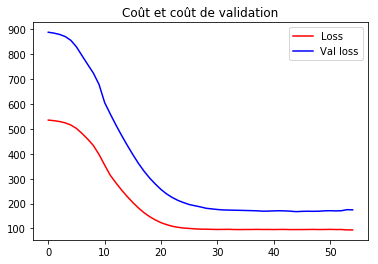

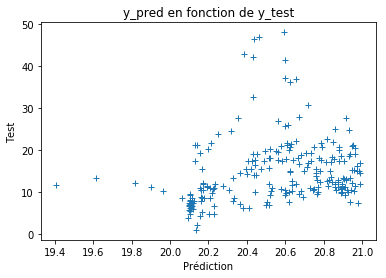

In [54]:
y_pred = model.predict(X_test)
plt.title('Coût et coût de validation')
line1,=plt.plot(history.history['loss'], label="Loss", linestyle='-', color='r')
line2,=plt.plot(history.history['val_loss'], label="Val loss", linestyle='-', color='b')
first_legend = plt.legend(handles=[line1, line2], loc=1)

plt.show()

plt.title('y_pred en fonction de y_test')

plt.plot(y_pred[:], y_test[:], '+')
plt.ylabel('Test')
plt.xlabel('Prédiction')
plt.show()